# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Check GPU Type

In [4]:
!nvidia-smi

Fri Jun  9 01:28:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P8     6W / 285W |   2192MiB / 12282MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [5]:
# Download Link
# Link 1 (Dropbox): https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
# Link 2 (Google Drive): https://drive.google.com/file/d/1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9/view?usp=share_link
# Link 3: Kaggle Competition.

# (1) dropbox link
# !wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0

# (2) google drive link
# !pip install gdown --upgrade
# !gdown --id '1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9' --output food11.zip

In [6]:
# ! unzip food11.zip

# Import Packages

In [7]:
_exp_name = "sample"

In [8]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import time
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random

from torchinfo import summary
from torchvision.models import resnet18
from torch.utils.tensorboard import SummaryWriter

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [10]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((256, 256)),
    # You may add some transforms here.
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomRotation(45),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [11]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
            
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
            
        return im,label

# Model

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
    
class MyClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.resnet18 = resnet18(num_classes = 11)
        # self.fc = nn.Linear(1000, 11)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.resnet18(x)
        return y

# Configurations

In [13]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyClassifier().to(device)

# The number of batch size.
batch_size = 176

# The number of training epochs.
n_epochs = 500

# If no improvement in 'patience' epochs, early stop.
patience = 30

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=3e-6)

In [14]:
summary(model,input_size=[batch_size,3,256,256],col_names=("input_size","output_size", "num_params"))

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
MyClassifier                                  [176, 3, 256, 256]        [176, 11]                 --
├─ResNet: 1-1                                 [176, 3, 256, 256]        [176, 11]                 --
│    └─Conv2d: 2-1                            [176, 3, 256, 256]        [176, 64, 128, 128]       9,408
│    └─BatchNorm2d: 2-2                       [176, 64, 128, 128]       [176, 64, 128, 128]       128
│    └─ReLU: 2-3                              [176, 64, 128, 128]       [176, 64, 128, 128]       --
│    └─MaxPool2d: 2-4                         [176, 64, 128, 128]       [176, 64, 64, 64]         --
│    └─Sequential: 2-5                        [176, 64, 64, 64]         [176, 64, 64, 64]         --
│    │    └─BasicBlock: 3-1                   [176, 64, 64, 64]         [176, 64, 64, 64]         73,984
│    │    └─BasicBlock: 3-2                   [176, 64, 64, 64]         [176, 

# Dataloader

In [15]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Start Training

In [33]:
writer = SummaryWriter(f"runs/{time.strftime('%Y-%m-%d_%H-%M-%S')}")
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for i,(batch) in enumerate(tqdm(train_loader)):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

        writer.add_scalar('Loss/Train', loss.item(), len(train_loader) * epoch + i)
        writer.add_scalar('Acc/Train', acc, len(train_loader) * epoch + i)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    scheduler.step()
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    writer.add_scalar('Loss/Val', valid_loss, epoch)
    writer.add_scalar('Acc/Val', valid_acc, epoch)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

100%|██████████| 57/57 [01:56<00:00,  2.04s/it]


[ Train | 001/500 ] loss = 2.09169, acc = 0.27458


100%|██████████| 21/21 [00:32<00:00,  1.57s/it]


[ Valid | 001/500 ] loss = 2.20851, acc = 0.25798
[ Valid | 001/500 ] loss = 2.20851, acc = 0.25798 -> best
Best model found at epoch 0, saving model


100%|██████████| 57/57 [01:54<00:00,  2.02s/it]


[ Train | 002/500 ] loss = 1.88026, acc = 0.34369


100%|██████████| 21/21 [00:31<00:00,  1.52s/it]


[ Valid | 002/500 ] loss = 1.95775, acc = 0.31596
[ Valid | 002/500 ] loss = 1.95775, acc = 0.31596 -> best
Best model found at epoch 1, saving model


100%|██████████| 57/57 [01:54<00:00,  2.00s/it]


[ Train | 003/500 ] loss = 1.76900, acc = 0.38441


100%|██████████| 21/21 [00:32<00:00,  1.56s/it]


[ Valid | 003/500 ] loss = 1.90958, acc = 0.36286
[ Valid | 003/500 ] loss = 1.90958, acc = 0.36286 -> best
Best model found at epoch 2, saving model


100%|██████████| 57/57 [01:55<00:00,  2.02s/it]


[ Train | 004/500 ] loss = 1.68968, acc = 0.41682


100%|██████████| 21/21 [00:29<00:00,  1.42s/it]


[ Valid | 004/500 ] loss = 1.75603, acc = 0.39168
[ Valid | 004/500 ] loss = 1.75603, acc = 0.39168 -> best
Best model found at epoch 3, saving model


100%|██████████| 57/57 [01:52<00:00,  1.98s/it]


[ Train | 005/500 ] loss = 1.59994, acc = 0.44671


100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


[ Valid | 005/500 ] loss = 1.84937, acc = 0.39165
[ Valid | 005/500 ] loss = 1.84937, acc = 0.39165


100%|██████████| 57/57 [01:52<00:00,  1.97s/it]


[ Train | 006/500 ] loss = 1.52316, acc = 0.47216


100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


[ Valid | 006/500 ] loss = 1.92186, acc = 0.38516
[ Valid | 006/500 ] loss = 1.92186, acc = 0.38516


100%|██████████| 57/57 [01:57<00:00,  2.05s/it]


[ Train | 007/500 ] loss = 1.45671, acc = 0.49273


100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


[ Valid | 007/500 ] loss = 1.62544, acc = 0.45133
[ Valid | 007/500 ] loss = 1.62544, acc = 0.45133 -> best
Best model found at epoch 6, saving model


100%|██████████| 57/57 [01:55<00:00,  2.03s/it]


[ Train | 008/500 ] loss = 1.38174, acc = 0.52467


100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


[ Valid | 008/500 ] loss = 1.46338, acc = 0.48740
[ Valid | 008/500 ] loss = 1.46338, acc = 0.48740 -> best
Best model found at epoch 7, saving model


100%|██████████| 57/57 [02:00<00:00,  2.11s/it]


[ Train | 009/500 ] loss = 1.35673, acc = 0.53762


100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


[ Valid | 009/500 ] loss = 1.67421, acc = 0.42470
[ Valid | 009/500 ] loss = 1.67421, acc = 0.42470


100%|██████████| 57/57 [01:52<00:00,  1.97s/it]


[ Train | 010/500 ] loss = 1.29245, acc = 0.55300


100%|██████████| 21/21 [00:29<00:00,  1.42s/it]


[ Valid | 010/500 ] loss = 1.44482, acc = 0.50151
[ Valid | 010/500 ] loss = 1.44482, acc = 0.50151 -> best
Best model found at epoch 9, saving model


100%|██████████| 57/57 [01:53<00:00,  1.99s/it]


[ Train | 011/500 ] loss = 1.26765, acc = 0.56209


100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


[ Valid | 011/500 ] loss = 1.39337, acc = 0.52845
[ Valid | 011/500 ] loss = 1.39337, acc = 0.52845 -> best
Best model found at epoch 10, saving model


100%|██████████| 57/57 [01:53<00:00,  1.99s/it]


[ Train | 012/500 ] loss = 1.20604, acc = 0.58509


100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


[ Valid | 012/500 ] loss = 1.44357, acc = 0.51632
[ Valid | 012/500 ] loss = 1.44357, acc = 0.51632


100%|██████████| 57/57 [01:58<00:00,  2.08s/it]


[ Train | 013/500 ] loss = 1.15750, acc = 0.60051


100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


[ Valid | 013/500 ] loss = 1.48767, acc = 0.53185
[ Valid | 013/500 ] loss = 1.48767, acc = 0.53185 -> best
Best model found at epoch 12, saving model


100%|██████████| 57/57 [01:52<00:00,  1.98s/it]


[ Train | 014/500 ] loss = 1.12633, acc = 0.61294


100%|██████████| 21/21 [00:31<00:00,  1.51s/it]


[ Valid | 014/500 ] loss = 1.33210, acc = 0.54476
[ Valid | 014/500 ] loss = 1.33210, acc = 0.54476 -> best
Best model found at epoch 13, saving model


100%|██████████| 57/57 [01:54<00:00,  2.01s/it]


[ Train | 015/500 ] loss = 1.09390, acc = 0.62026


100%|██████████| 21/21 [00:29<00:00,  1.42s/it]


[ Valid | 015/500 ] loss = 1.16352, acc = 0.60208
[ Valid | 015/500 ] loss = 1.16352, acc = 0.60208 -> best
Best model found at epoch 14, saving model


100%|██████████| 57/57 [01:53<00:00,  1.99s/it]


[ Train | 016/500 ] loss = 1.05651, acc = 0.64219


100%|██████████| 21/21 [00:29<00:00,  1.38s/it]


[ Valid | 016/500 ] loss = 1.28814, acc = 0.57669
[ Valid | 016/500 ] loss = 1.28814, acc = 0.57669


100%|██████████| 57/57 [01:53<00:00,  1.99s/it]


[ Train | 017/500 ] loss = 1.02737, acc = 0.64686


100%|██████████| 21/21 [00:28<00:00,  1.38s/it]


[ Valid | 017/500 ] loss = 1.30923, acc = 0.55500
[ Valid | 017/500 ] loss = 1.30923, acc = 0.55500


100%|██████████| 57/57 [01:56<00:00,  2.04s/it]


[ Train | 018/500 ] loss = 0.99884, acc = 0.65511


100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


[ Valid | 018/500 ] loss = 1.19237, acc = 0.59548
[ Valid | 018/500 ] loss = 1.19237, acc = 0.59548


100%|██████████| 57/57 [01:53<00:00,  2.00s/it]


[ Train | 019/500 ] loss = 0.96574, acc = 0.66570


100%|██████████| 21/21 [00:30<00:00,  1.43s/it]


[ Valid | 019/500 ] loss = 1.25645, acc = 0.57557
[ Valid | 019/500 ] loss = 1.25645, acc = 0.57557


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 020/500 ] loss = 0.94443, acc = 0.67697


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 020/500 ] loss = 1.15332, acc = 0.59687
[ Valid | 020/500 ] loss = 1.15332, acc = 0.59687


100%|██████████| 57/57 [01:50<00:00,  1.94s/it]


[ Train | 021/500 ] loss = 0.92037, acc = 0.68409


100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


[ Valid | 021/500 ] loss = 1.16920, acc = 0.61929
[ Valid | 021/500 ] loss = 1.16920, acc = 0.61929 -> best
Best model found at epoch 20, saving model


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 022/500 ] loss = 0.87799, acc = 0.69765


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


[ Valid | 022/500 ] loss = 1.12647, acc = 0.62864
[ Valid | 022/500 ] loss = 1.12647, acc = 0.62864 -> best
Best model found at epoch 21, saving model


100%|██████████| 57/57 [01:51<00:00,  1.96s/it]


[ Train | 023/500 ] loss = 0.87716, acc = 0.70169


100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


[ Valid | 023/500 ] loss = 1.28845, acc = 0.58852
[ Valid | 023/500 ] loss = 1.28845, acc = 0.58852


100%|██████████| 57/57 [01:51<00:00,  1.96s/it]


[ Train | 024/500 ] loss = 0.83930, acc = 0.70941


100%|██████████| 21/21 [00:30<00:00,  1.46s/it]


[ Valid | 024/500 ] loss = 1.03002, acc = 0.64820
[ Valid | 024/500 ] loss = 1.03002, acc = 0.64820 -> best
Best model found at epoch 23, saving model


100%|██████████| 57/57 [01:50<00:00,  1.94s/it]


[ Train | 025/500 ] loss = 0.83566, acc = 0.70946


100%|██████████| 21/21 [00:28<00:00,  1.33s/it]


[ Valid | 025/500 ] loss = 1.03108, acc = 0.65891
[ Valid | 025/500 ] loss = 1.03108, acc = 0.65891 -> best
Best model found at epoch 24, saving model


100%|██████████| 57/57 [01:46<00:00,  1.87s/it]


[ Train | 026/500 ] loss = 0.79438, acc = 0.72281


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


[ Valid | 026/500 ] loss = 1.30960, acc = 0.57437
[ Valid | 026/500 ] loss = 1.30960, acc = 0.57437


100%|██████████| 57/57 [01:46<00:00,  1.87s/it]


[ Train | 027/500 ] loss = 0.78880, acc = 0.73119


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


[ Valid | 027/500 ] loss = 1.03478, acc = 0.65829
[ Valid | 027/500 ] loss = 1.03478, acc = 0.65829


100%|██████████| 57/57 [01:53<00:00,  2.00s/it]


[ Train | 028/500 ] loss = 0.75629, acc = 0.74477


100%|██████████| 21/21 [00:33<00:00,  1.58s/it]


[ Valid | 028/500 ] loss = 1.03350, acc = 0.65694
[ Valid | 028/500 ] loss = 1.03350, acc = 0.65694


100%|██████████| 57/57 [01:51<00:00,  1.96s/it]


[ Train | 029/500 ] loss = 0.74360, acc = 0.74431


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


[ Valid | 029/500 ] loss = 1.06614, acc = 0.64569
[ Valid | 029/500 ] loss = 1.06614, acc = 0.64569


100%|██████████| 57/57 [01:45<00:00,  1.86s/it]


[ Train | 030/500 ] loss = 0.70859, acc = 0.75121


100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


[ Valid | 030/500 ] loss = 1.09195, acc = 0.65562
[ Valid | 030/500 ] loss = 1.09195, acc = 0.65562


100%|██████████| 57/57 [01:48<00:00,  1.91s/it]


[ Train | 031/500 ] loss = 0.71419, acc = 0.75456


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


[ Valid | 031/500 ] loss = 0.87666, acc = 0.69864
[ Valid | 031/500 ] loss = 0.87666, acc = 0.69864 -> best
Best model found at epoch 30, saving model


100%|██████████| 57/57 [01:50<00:00,  1.93s/it]


[ Train | 032/500 ] loss = 0.68327, acc = 0.76551


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


[ Valid | 032/500 ] loss = 0.98604, acc = 0.67109
[ Valid | 032/500 ] loss = 0.98604, acc = 0.67109


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 033/500 ] loss = 0.67262, acc = 0.76561


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


[ Valid | 033/500 ] loss = 0.94327, acc = 0.68995
[ Valid | 033/500 ] loss = 0.94327, acc = 0.68995


100%|██████████| 57/57 [01:46<00:00,  1.87s/it]


[ Train | 034/500 ] loss = 0.64902, acc = 0.77503


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


[ Valid | 034/500 ] loss = 1.01867, acc = 0.66726
[ Valid | 034/500 ] loss = 1.01867, acc = 0.66726


100%|██████████| 57/57 [01:48<00:00,  1.91s/it]


[ Train | 035/500 ] loss = 0.62811, acc = 0.78111


100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


[ Valid | 035/500 ] loss = 1.06229, acc = 0.68180
[ Valid | 035/500 ] loss = 1.06229, acc = 0.68180


100%|██████████| 57/57 [01:48<00:00,  1.91s/it]


[ Train | 036/500 ] loss = 0.62235, acc = 0.78548


100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


[ Valid | 036/500 ] loss = 0.89403, acc = 0.70959
[ Valid | 036/500 ] loss = 0.89403, acc = 0.70959 -> best
Best model found at epoch 35, saving model


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 037/500 ] loss = 0.61189, acc = 0.78682


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 037/500 ] loss = 0.89901, acc = 0.71132
[ Valid | 037/500 ] loss = 0.89901, acc = 0.71132 -> best
Best model found at epoch 36, saving model


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 038/500 ] loss = 0.58908, acc = 0.79488


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


[ Valid | 038/500 ] loss = 1.13051, acc = 0.65118
[ Valid | 038/500 ] loss = 1.13051, acc = 0.65118


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 039/500 ] loss = 0.56553, acc = 0.80613


100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


[ Valid | 039/500 ] loss = 0.92445, acc = 0.70785
[ Valid | 039/500 ] loss = 0.92445, acc = 0.70785


100%|██████████| 57/57 [01:45<00:00,  1.86s/it]


[ Train | 040/500 ] loss = 0.54625, acc = 0.80731


100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


[ Valid | 040/500 ] loss = 0.86985, acc = 0.72169
[ Valid | 040/500 ] loss = 0.86985, acc = 0.72169 -> best
Best model found at epoch 39, saving model


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 041/500 ] loss = 0.53666, acc = 0.81272


100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


[ Valid | 041/500 ] loss = 0.97787, acc = 0.69045
[ Valid | 041/500 ] loss = 0.97787, acc = 0.69045


100%|██████████| 57/57 [01:46<00:00,  1.87s/it]


[ Train | 042/500 ] loss = 0.53690, acc = 0.81219


100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


[ Valid | 042/500 ] loss = 1.13771, acc = 0.65860
[ Valid | 042/500 ] loss = 1.13771, acc = 0.65860


100%|██████████| 57/57 [01:46<00:00,  1.87s/it]


[ Train | 043/500 ] loss = 0.52373, acc = 0.81782


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


[ Valid | 043/500 ] loss = 0.81608, acc = 0.73866
[ Valid | 043/500 ] loss = 0.81608, acc = 0.73866 -> best
Best model found at epoch 42, saving model


100%|██████████| 57/57 [01:50<00:00,  1.93s/it]


[ Train | 044/500 ] loss = 0.49671, acc = 0.82599


100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


[ Valid | 044/500 ] loss = 1.02409, acc = 0.69053
[ Valid | 044/500 ] loss = 1.02409, acc = 0.69053


100%|██████████| 57/57 [01:46<00:00,  1.87s/it]


[ Train | 045/500 ] loss = 0.50003, acc = 0.82457


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


[ Valid | 045/500 ] loss = 0.71461, acc = 0.76931
[ Valid | 045/500 ] loss = 0.71461, acc = 0.76931 -> best
Best model found at epoch 44, saving model


100%|██████████| 57/57 [01:46<00:00,  1.86s/it]


[ Train | 046/500 ] loss = 0.47049, acc = 0.83756


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


[ Valid | 046/500 ] loss = 0.90785, acc = 0.72412
[ Valid | 046/500 ] loss = 0.90785, acc = 0.72412


100%|██████████| 57/57 [01:43<00:00,  1.82s/it]


[ Train | 047/500 ] loss = 0.45412, acc = 0.84315


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 047/500 ] loss = 0.74443, acc = 0.76351
[ Valid | 047/500 ] loss = 0.74443, acc = 0.76351


100%|██████████| 57/57 [01:46<00:00,  1.88s/it]


[ Train | 048/500 ] loss = 0.44323, acc = 0.85100


100%|██████████| 21/21 [00:28<00:00,  1.38s/it]


[ Valid | 048/500 ] loss = 0.81817, acc = 0.73224
[ Valid | 048/500 ] loss = 0.81817, acc = 0.73224


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 049/500 ] loss = 0.43630, acc = 0.84680


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 049/500 ] loss = 0.83369, acc = 0.73758
[ Valid | 049/500 ] loss = 0.83369, acc = 0.73758


100%|██████████| 57/57 [01:46<00:00,  1.88s/it]


[ Train | 050/500 ] loss = 0.43165, acc = 0.84886


100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


[ Valid | 050/500 ] loss = 0.91371, acc = 0.72505
[ Valid | 050/500 ] loss = 0.91371, acc = 0.72505


100%|██████████| 57/57 [01:49<00:00,  1.91s/it]


[ Train | 051/500 ] loss = 0.39963, acc = 0.85948


100%|██████████| 21/21 [00:29<00:00,  1.43s/it]


[ Valid | 051/500 ] loss = 0.74183, acc = 0.75605
[ Valid | 051/500 ] loss = 0.74183, acc = 0.75605


100%|██████████| 57/57 [01:46<00:00,  1.87s/it]


[ Train | 052/500 ] loss = 0.38826, acc = 0.86616


100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


[ Valid | 052/500 ] loss = 0.76303, acc = 0.75771
[ Valid | 052/500 ] loss = 0.76303, acc = 0.75771


100%|██████████| 57/57 [01:46<00:00,  1.87s/it]


[ Train | 053/500 ] loss = 0.38047, acc = 0.86783


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


[ Valid | 053/500 ] loss = 0.82659, acc = 0.74279
[ Valid | 053/500 ] loss = 0.82659, acc = 0.74279


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 054/500 ] loss = 0.36114, acc = 0.87609


100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


[ Valid | 054/500 ] loss = 0.81323, acc = 0.75655
[ Valid | 054/500 ] loss = 0.81323, acc = 0.75655


100%|██████████| 57/57 [01:46<00:00,  1.87s/it]


[ Train | 055/500 ] loss = 0.35439, acc = 0.87953


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


[ Valid | 055/500 ] loss = 0.74608, acc = 0.77105
[ Valid | 055/500 ] loss = 0.74608, acc = 0.77105 -> best
Best model found at epoch 54, saving model


100%|██████████| 57/57 [01:47<00:00,  1.88s/it]


[ Train | 056/500 ] loss = 0.32368, acc = 0.88924


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 056/500 ] loss = 0.66962, acc = 0.78446
[ Valid | 056/500 ] loss = 0.66962, acc = 0.78446 -> best
Best model found at epoch 55, saving model


100%|██████████| 57/57 [01:45<00:00,  1.84s/it]


[ Train | 057/500 ] loss = 0.32222, acc = 0.88816


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 057/500 ] loss = 0.82738, acc = 0.76220
[ Valid | 057/500 ] loss = 0.82738, acc = 0.76220


100%|██████████| 57/57 [01:46<00:00,  1.86s/it]


[ Train | 058/500 ] loss = 0.30955, acc = 0.89332


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 058/500 ] loss = 0.76054, acc = 0.77040
[ Valid | 058/500 ] loss = 0.76054, acc = 0.77040


100%|██████████| 57/57 [01:45<00:00,  1.85s/it]


[ Train | 059/500 ] loss = 0.30105, acc = 0.89583


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


[ Valid | 059/500 ] loss = 0.74240, acc = 0.76811
[ Valid | 059/500 ] loss = 0.74240, acc = 0.76811


100%|██████████| 57/57 [01:48<00:00,  1.91s/it]


[ Train | 060/500 ] loss = 0.29373, acc = 0.89814


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


[ Valid | 060/500 ] loss = 0.72586, acc = 0.77909
[ Valid | 060/500 ] loss = 0.72586, acc = 0.77909


100%|██████████| 57/57 [01:48<00:00,  1.91s/it]


[ Train | 061/500 ] loss = 0.27784, acc = 0.90169


100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


[ Valid | 061/500 ] loss = 0.85136, acc = 0.75740
[ Valid | 061/500 ] loss = 0.85136, acc = 0.75740


100%|██████████| 57/57 [01:46<00:00,  1.88s/it]


[ Train | 062/500 ] loss = 0.27117, acc = 0.90466


100%|██████████| 21/21 [00:28<00:00,  1.38s/it]


[ Valid | 062/500 ] loss = 0.77231, acc = 0.77603
[ Valid | 062/500 ] loss = 0.77231, acc = 0.77603


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 063/500 ] loss = 0.26349, acc = 0.91040


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 063/500 ] loss = 0.90091, acc = 0.75153
[ Valid | 063/500 ] loss = 0.90091, acc = 0.75153


100%|██████████| 57/57 [01:44<00:00,  1.83s/it]


[ Train | 064/500 ] loss = 0.25334, acc = 0.91188


100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


[ Valid | 064/500 ] loss = 0.77387, acc = 0.77565
[ Valid | 064/500 ] loss = 0.77387, acc = 0.77565


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 065/500 ] loss = 0.22982, acc = 0.92101


100%|██████████| 21/21 [00:29<00:00,  1.42s/it]


[ Valid | 065/500 ] loss = 0.74971, acc = 0.77847
[ Valid | 065/500 ] loss = 0.74971, acc = 0.77847


100%|██████████| 57/57 [01:50<00:00,  1.94s/it]


[ Train | 066/500 ] loss = 0.23713, acc = 0.91969


100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


[ Valid | 066/500 ] loss = 0.67274, acc = 0.79676
[ Valid | 066/500 ] loss = 0.67274, acc = 0.79676 -> best
Best model found at epoch 65, saving model


100%|██████████| 57/57 [01:50<00:00,  1.93s/it]


[ Train | 067/500 ] loss = 0.22316, acc = 0.92336


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 067/500 ] loss = 0.67913, acc = 0.80367
[ Valid | 067/500 ] loss = 0.67913, acc = 0.80367 -> best
Best model found at epoch 66, saving model


100%|██████████| 57/57 [01:49<00:00,  1.91s/it]


[ Train | 068/500 ] loss = 0.19702, acc = 0.93469


100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


[ Valid | 068/500 ] loss = 0.70470, acc = 0.78558
[ Valid | 068/500 ] loss = 0.70470, acc = 0.78558


100%|██████████| 57/57 [01:49<00:00,  1.92s/it]


[ Train | 069/500 ] loss = 0.20137, acc = 0.93015


100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


[ Valid | 069/500 ] loss = 0.65156, acc = 0.80402
[ Valid | 069/500 ] loss = 0.65156, acc = 0.80402 -> best
Best model found at epoch 68, saving model


100%|██████████| 57/57 [01:49<00:00,  1.92s/it]


[ Train | 070/500 ] loss = 0.18661, acc = 0.93747


100%|██████████| 21/21 [00:28<00:00,  1.38s/it]


[ Valid | 070/500 ] loss = 0.69714, acc = 0.80027
[ Valid | 070/500 ] loss = 0.69714, acc = 0.80027


100%|██████████| 57/57 [01:49<00:00,  1.93s/it]


[ Train | 071/500 ] loss = 0.17494, acc = 0.94171


100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


[ Valid | 071/500 ] loss = 0.69489, acc = 0.80074
[ Valid | 071/500 ] loss = 0.69489, acc = 0.80074


100%|██████████| 57/57 [01:47<00:00,  1.88s/it]


[ Train | 072/500 ] loss = 0.17727, acc = 0.93997


100%|██████████| 21/21 [00:28<00:00,  1.33s/it]


[ Valid | 072/500 ] loss = 0.69800, acc = 0.79957
[ Valid | 072/500 ] loss = 0.69800, acc = 0.79957


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 073/500 ] loss = 0.17708, acc = 0.94041


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 073/500 ] loss = 0.72167, acc = 0.79536
[ Valid | 073/500 ] loss = 0.72167, acc = 0.79536


100%|██████████| 57/57 [01:49<00:00,  1.92s/it]


[ Train | 074/500 ] loss = 0.16664, acc = 0.94353


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


[ Valid | 074/500 ] loss = 0.68682, acc = 0.80978
[ Valid | 074/500 ] loss = 0.68682, acc = 0.80978 -> best
Best model found at epoch 73, saving model


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 075/500 ] loss = 0.15666, acc = 0.94777


100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


[ Valid | 075/500 ] loss = 0.67599, acc = 0.81253
[ Valid | 075/500 ] loss = 0.67599, acc = 0.81253 -> best
Best model found at epoch 74, saving model


100%|██████████| 57/57 [01:52<00:00,  1.97s/it]


[ Train | 076/500 ] loss = 0.14824, acc = 0.95136


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


[ Valid | 076/500 ] loss = 0.67884, acc = 0.80805
[ Valid | 076/500 ] loss = 0.67884, acc = 0.80805


100%|██████████| 57/57 [01:46<00:00,  1.87s/it]


[ Train | 077/500 ] loss = 0.13988, acc = 0.95519


100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


[ Valid | 077/500 ] loss = 0.66708, acc = 0.81144
[ Valid | 077/500 ] loss = 0.66708, acc = 0.81144


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 078/500 ] loss = 0.14098, acc = 0.95564


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


[ Valid | 078/500 ] loss = 0.65697, acc = 0.81720
[ Valid | 078/500 ] loss = 0.65697, acc = 0.81720 -> best
Best model found at epoch 77, saving model


100%|██████████| 57/57 [01:45<00:00,  1.85s/it]


[ Train | 079/500 ] loss = 0.12685, acc = 0.95989


100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


[ Valid | 079/500 ] loss = 0.66998, acc = 0.81376
[ Valid | 079/500 ] loss = 0.66998, acc = 0.81376


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 080/500 ] loss = 0.12528, acc = 0.95986


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 080/500 ] loss = 0.67764, acc = 0.81021
[ Valid | 080/500 ] loss = 0.67764, acc = 0.81021


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 081/500 ] loss = 0.12448, acc = 0.96026


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


[ Valid | 081/500 ] loss = 0.68442, acc = 0.80653
[ Valid | 081/500 ] loss = 0.68442, acc = 0.80653


100%|██████████| 57/57 [01:50<00:00,  1.93s/it]


[ Train | 082/500 ] loss = 0.11556, acc = 0.96438


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


[ Valid | 082/500 ] loss = 0.67069, acc = 0.81415
[ Valid | 082/500 ] loss = 0.67069, acc = 0.81415


100%|██████████| 57/57 [01:48<00:00,  1.91s/it]


[ Train | 083/500 ] loss = 0.11928, acc = 0.95946


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


[ Valid | 083/500 ] loss = 0.68291, acc = 0.81473
[ Valid | 083/500 ] loss = 0.68291, acc = 0.81473


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 084/500 ] loss = 0.10656, acc = 0.96622


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


[ Valid | 084/500 ] loss = 0.65869, acc = 0.81774
[ Valid | 084/500 ] loss = 0.65869, acc = 0.81774 -> best
Best model found at epoch 83, saving model


100%|██████████| 57/57 [01:49<00:00,  1.91s/it]


[ Train | 085/500 ] loss = 0.10795, acc = 0.96645


100%|██████████| 21/21 [00:29<00:00,  1.41s/it]


[ Valid | 085/500 ] loss = 0.65461, acc = 0.81886
[ Valid | 085/500 ] loss = 0.65461, acc = 0.81886 -> best
Best model found at epoch 84, saving model


100%|██████████| 57/57 [01:50<00:00,  1.93s/it]


[ Train | 086/500 ] loss = 0.10289, acc = 0.96838


100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


[ Valid | 086/500 ] loss = 0.65275, acc = 0.82003
[ Valid | 086/500 ] loss = 0.65275, acc = 0.82003 -> best
Best model found at epoch 85, saving model


100%|██████████| 57/57 [01:51<00:00,  1.95s/it]


[ Train | 087/500 ] loss = 0.09995, acc = 0.97090


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


[ Valid | 087/500 ] loss = 0.65033, acc = 0.82107
[ Valid | 087/500 ] loss = 0.65033, acc = 0.82107 -> best
Best model found at epoch 86, saving model


100%|██████████| 57/57 [01:50<00:00,  1.93s/it]


[ Train | 088/500 ] loss = 0.09369, acc = 0.97104


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


[ Valid | 088/500 ] loss = 0.65619, acc = 0.82288
[ Valid | 088/500 ] loss = 0.65619, acc = 0.82288 -> best
Best model found at epoch 87, saving model


100%|██████████| 57/57 [01:49<00:00,  1.91s/it]


[ Train | 089/500 ] loss = 0.09494, acc = 0.97196


100%|██████████| 21/21 [00:29<00:00,  1.40s/it]


[ Valid | 089/500 ] loss = 0.66113, acc = 0.81565
[ Valid | 089/500 ] loss = 0.66113, acc = 0.81565


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 090/500 ] loss = 0.09289, acc = 0.97317


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


[ Valid | 090/500 ] loss = 0.66006, acc = 0.81867
[ Valid | 090/500 ] loss = 0.66006, acc = 0.81867


100%|██████████| 57/57 [01:46<00:00,  1.86s/it]


[ Train | 091/500 ] loss = 0.08986, acc = 0.97389


100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


[ Valid | 091/500 ] loss = 0.65290, acc = 0.82010
[ Valid | 091/500 ] loss = 0.65290, acc = 0.82010


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 092/500 ] loss = 0.09806, acc = 0.97228


100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


[ Valid | 092/500 ] loss = 0.65034, acc = 0.81952
[ Valid | 092/500 ] loss = 0.65034, acc = 0.81952


100%|██████████| 57/57 [01:44<00:00,  1.83s/it]


[ Train | 093/500 ] loss = 0.08530, acc = 0.97641


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


[ Valid | 093/500 ] loss = 0.65113, acc = 0.82424
[ Valid | 093/500 ] loss = 0.65113, acc = 0.82424 -> best
Best model found at epoch 92, saving model


100%|██████████| 57/57 [01:43<00:00,  1.81s/it]


[ Train | 094/500 ] loss = 0.09208, acc = 0.97284


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


[ Valid | 094/500 ] loss = 0.65538, acc = 0.81929
[ Valid | 094/500 ] loss = 0.65538, acc = 0.81929


100%|██████████| 57/57 [01:45<00:00,  1.85s/it]


[ Train | 095/500 ] loss = 0.08898, acc = 0.97399


100%|██████████| 21/21 [00:26<00:00,  1.29s/it]


[ Valid | 095/500 ] loss = 0.65267, acc = 0.82223
[ Valid | 095/500 ] loss = 0.65267, acc = 0.82223


100%|██████████| 57/57 [01:43<00:00,  1.81s/it]


[ Train | 096/500 ] loss = 0.08583, acc = 0.97587


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


[ Valid | 096/500 ] loss = 0.65665, acc = 0.81751
[ Valid | 096/500 ] loss = 0.65665, acc = 0.81751


100%|██████████| 57/57 [01:43<00:00,  1.81s/it]


[ Train | 097/500 ] loss = 0.08720, acc = 0.97603


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


[ Valid | 097/500 ] loss = 0.65885, acc = 0.82075
[ Valid | 097/500 ] loss = 0.65885, acc = 0.82075


100%|██████████| 57/57 [01:43<00:00,  1.81s/it]


[ Train | 098/500 ] loss = 0.08088, acc = 0.97918


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


[ Valid | 098/500 ] loss = 0.65530, acc = 0.81878
[ Valid | 098/500 ] loss = 0.65530, acc = 0.81878


100%|██████████| 57/57 [01:43<00:00,  1.81s/it]


[ Train | 099/500 ] loss = 0.08809, acc = 0.97360


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


[ Valid | 099/500 ] loss = 0.65295, acc = 0.81975
[ Valid | 099/500 ] loss = 0.65295, acc = 0.81975


100%|██████████| 57/57 [01:51<00:00,  1.96s/it]


[ Train | 100/500 ] loss = 0.08420, acc = 0.97641


100%|██████████| 21/21 [00:29<00:00,  1.42s/it]


[ Valid | 100/500 ] loss = 0.65556, acc = 0.82107
[ Valid | 100/500 ] loss = 0.65556, acc = 0.82107


100%|██████████| 57/57 [02:03<00:00,  2.17s/it]


[ Train | 101/500 ] loss = 0.70087, acc = 0.77729


100%|██████████| 21/21 [00:47<00:00,  2.26s/it]


[ Valid | 101/500 ] loss = 1.26173, acc = 0.62795
[ Valid | 101/500 ] loss = 1.26173, acc = 0.62795


100%|██████████| 57/57 [01:59<00:00,  2.10s/it]


[ Train | 102/500 ] loss = 0.55199, acc = 0.80808


100%|██████████| 21/21 [00:31<00:00,  1.48s/it]


[ Valid | 102/500 ] loss = 1.31349, acc = 0.61484
[ Valid | 102/500 ] loss = 1.31349, acc = 0.61484


100%|██████████| 57/57 [01:51<00:00,  1.96s/it]


[ Train | 103/500 ] loss = 0.46421, acc = 0.83946


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


[ Valid | 103/500 ] loss = 1.10003, acc = 0.68109
[ Valid | 103/500 ] loss = 1.10003, acc = 0.68109


100%|██████████| 57/57 [01:43<00:00,  1.82s/it]


[ Train | 104/500 ] loss = 0.45406, acc = 0.83944


100%|██████████| 21/21 [00:28<00:00,  1.38s/it]


[ Valid | 104/500 ] loss = 1.45990, acc = 0.58152
[ Valid | 104/500 ] loss = 1.45990, acc = 0.58152


100%|██████████| 57/57 [01:44<00:00,  1.84s/it]


[ Train | 105/500 ] loss = 0.42050, acc = 0.85357


100%|██████████| 21/21 [00:29<00:00,  1.39s/it]


[ Valid | 105/500 ] loss = 1.03401, acc = 0.68578
[ Valid | 105/500 ] loss = 1.03401, acc = 0.68578


100%|██████████| 57/57 [01:44<00:00,  1.83s/it]


[ Train | 106/500 ] loss = 0.40346, acc = 0.85553


100%|██████████| 21/21 [00:26<00:00,  1.26s/it]


[ Valid | 106/500 ] loss = 1.62734, acc = 0.60958
[ Valid | 106/500 ] loss = 1.62734, acc = 0.60958


100%|██████████| 57/57 [01:41<00:00,  1.78s/it]


[ Train | 107/500 ] loss = 0.39306, acc = 0.85888


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


[ Valid | 107/500 ] loss = 1.01241, acc = 0.70588
[ Valid | 107/500 ] loss = 1.01241, acc = 0.70588


100%|██████████| 57/57 [01:48<00:00,  1.91s/it]


[ Train | 108/500 ] loss = 0.39289, acc = 0.86266


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


[ Valid | 108/500 ] loss = 1.05844, acc = 0.69424
[ Valid | 108/500 ] loss = 1.05844, acc = 0.69424


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 109/500 ] loss = 0.37256, acc = 0.86616


100%|██████████| 21/21 [00:28<00:00,  1.35s/it]


[ Valid | 109/500 ] loss = 1.00744, acc = 0.71786
[ Valid | 109/500 ] loss = 1.00744, acc = 0.71786


100%|██████████| 57/57 [01:44<00:00,  1.83s/it]


[ Train | 110/500 ] loss = 0.36203, acc = 0.87173


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


[ Valid | 110/500 ] loss = 1.02919, acc = 0.71824
[ Valid | 110/500 ] loss = 1.02919, acc = 0.71824


100%|██████████| 57/57 [01:48<00:00,  1.90s/it]


[ Train | 111/500 ] loss = 0.34994, acc = 0.87789


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


[ Valid | 111/500 ] loss = 0.91347, acc = 0.73707
[ Valid | 111/500 ] loss = 0.91347, acc = 0.73707


100%|██████████| 57/57 [01:48<00:00,  1.91s/it]


[ Train | 112/500 ] loss = 0.33217, acc = 0.88718


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


[ Valid | 112/500 ] loss = 0.84888, acc = 0.74786
[ Valid | 112/500 ] loss = 0.84888, acc = 0.74786


100%|██████████| 57/57 [01:46<00:00,  1.86s/it]


[ Train | 113/500 ] loss = 0.32692, acc = 0.88456


100%|██████████| 21/21 [00:28<00:00,  1.33s/it]


[ Valid | 113/500 ] loss = 1.22125, acc = 0.66560
[ Valid | 113/500 ] loss = 1.22125, acc = 0.66560


100%|██████████| 57/57 [01:43<00:00,  1.82s/it]


[ Train | 114/500 ] loss = 0.32171, acc = 0.88616


100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


[ Valid | 114/500 ] loss = 1.02984, acc = 0.72226
[ Valid | 114/500 ] loss = 1.02984, acc = 0.72226


100%|██████████| 57/57 [01:42<00:00,  1.81s/it]


[ Train | 115/500 ] loss = 0.28704, acc = 0.89779


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


[ Valid | 115/500 ] loss = 1.00942, acc = 0.73131
[ Valid | 115/500 ] loss = 1.00942, acc = 0.73131


100%|██████████| 57/57 [01:43<00:00,  1.82s/it]


[ Train | 116/500 ] loss = 0.28373, acc = 0.90106


100%|██████████| 21/21 [00:26<00:00,  1.24s/it]


[ Valid | 116/500 ] loss = 1.04772, acc = 0.72350
[ Valid | 116/500 ] loss = 1.04772, acc = 0.72350


100%|██████████| 57/57 [01:42<00:00,  1.80s/it]


[ Train | 117/500 ] loss = 0.27635, acc = 0.90001


100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


[ Valid | 117/500 ] loss = 1.26313, acc = 0.69246
[ Valid | 117/500 ] loss = 1.26313, acc = 0.69246


100%|██████████| 57/57 [01:42<00:00,  1.80s/it]


[ Train | 118/500 ] loss = 0.29126, acc = 0.89763


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


[ Valid | 118/500 ] loss = 0.87582, acc = 0.75722
[ Valid | 118/500 ] loss = 0.87582, acc = 0.75722


100%|██████████| 57/57 [01:44<00:00,  1.84s/it]


[ Train | 119/500 ] loss = 0.27064, acc = 0.90404


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


[ Valid | 119/500 ] loss = 1.15870, acc = 0.70189
[ Valid | 119/500 ] loss = 1.15870, acc = 0.70189


100%|██████████| 57/57 [01:44<00:00,  1.84s/it]


[ Train | 120/500 ] loss = 0.26029, acc = 0.90590


100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


[ Valid | 120/500 ] loss = 0.90216, acc = 0.74174
[ Valid | 120/500 ] loss = 0.90216, acc = 0.74174


100%|██████████| 57/57 [01:43<00:00,  1.82s/it]


[ Train | 121/500 ] loss = 0.24345, acc = 0.91042


100%|██████████| 21/21 [00:26<00:00,  1.25s/it]


[ Valid | 121/500 ] loss = 0.85545, acc = 0.76908
[ Valid | 121/500 ] loss = 0.85545, acc = 0.76908


100%|██████████| 57/57 [01:43<00:00,  1.82s/it]


[ Train | 122/500 ] loss = 0.23554, acc = 0.91592


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


[ Valid | 122/500 ] loss = 0.94253, acc = 0.73595
[ Valid | 122/500 ] loss = 0.94253, acc = 0.73595


100%|██████████| 57/57 [01:47<00:00,  1.89s/it]


[ Train | 123/500 ] loss = 0.22010, acc = 0.92368


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


[ Valid | 123/500 ] loss = 0.79529, acc = 0.78434
[ Valid | 123/500 ] loss = 0.79529, acc = 0.78434


100%|██████████| 57/57 [01:42<00:00,  1.80s/it]


[ Train | 124/500 ] loss = 0.22071, acc = 0.92315


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]

[ Valid | 124/500 ] loss = 0.84325, acc = 0.77677
[ Valid | 124/500 ] loss = 0.84325, acc = 0.77677
No improvment 30 consecutive epochs, early stopping


# Dataloader for test

In [16]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("./test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Testing and generate prediction CSV

In [15]:
model_best = MyClassifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


In [16]:
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice. 
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [ ]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You can add some transforms here.
    transforms.ToTensor(),
])

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images). 


In [25]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = MyClassifier().to(device)
state_dict = torch.load(f"{_exp_name}_best.ckpt")
model.load_state_dict(state_dict)
model = nn.Sequential(*list(model.resnet18.children()))
model.eval()

print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

100%|██████████| 57/57 [00:29<00:00,  1.96it/s]


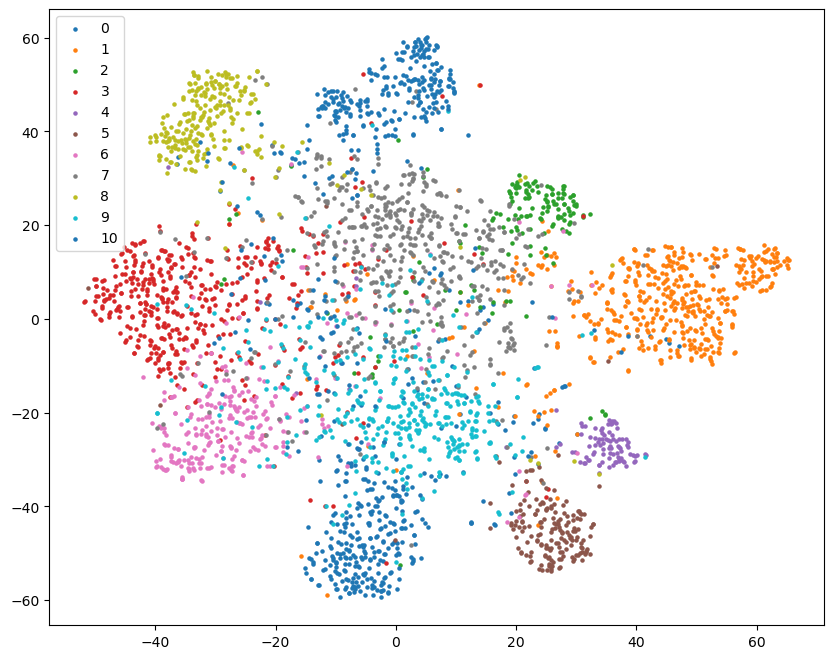

In [33]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 9 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()